In [1]:
from llama.modeling_llama import LlamaForCausalLM
from transformers import AutoTokenizer
import torch
from copy import deepcopy
from tqdm import tqdm

In [2]:
model = LlamaForCausalLM.from_pretrained("/home/mfx/huggingface/Llama-3.2-1B-Instruct", attn_implementation="eager", device_map='cuda:0')
tokenizer = AutoTokenizer.from_pretrained("/home/mfx/huggingface/Llama-3.2-1B-Instruct")
model

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /home/mfx/huggingface/Llama-3.2-1B-Instruct and are newly initialized: ['model.layers.0.self_attn.k_up_proj.weight', 'model.layers.0.self_attn.v_up_proj.weight', 'model.layers.1.self_attn.k_up_proj.weight', 'model.layers.1.self_attn.v_up_proj.weight', 'model.layers.10.self_attn.k_up_proj.weight', 'model.layers.10.self_attn.v_up_proj.weight', 'model.layers.11.self_attn.k_up_proj.weight', 'model.layers.11.self_attn.v_up_proj.weight', 'model.layers.12.self_attn.k_up_proj.weight', 'model.layers.12.self_attn.v_up_proj.weight', 'model.layers.13.self_attn.k_up_proj.weight', 'model.layers.13.self_attn.v_up_proj.weight', 'model.layers.14.self_attn.k_up_proj.weight', 'model.layers.14.self_attn.v_up_proj.weight', 'model.layers.15.self_attn.k_up_proj.weight', 'model.layers.15.self_attn.v_up_proj.weight', 'model.layers.2.self_attn.k_up_proj.weight', 'model.layers.2.self_attn.v_up_proj.weight', 'model.layers.3.self_at

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaMLAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (k_up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )


In [3]:
hidden_size = model.config.hidden_size
n_heads = model.config.num_attention_heads
kv_heads = model.config.num_key_value_heads
head_dim = model.config.head_dim
kv_groups = model.config.num_attention_heads // model.config.num_key_value_heads

In [4]:
# Insert identity matrices
for name,module in model.named_modules():
    if 'k_up_proj' in name or "v_up_proj" in name:
        module.weight.data = torch.stack([torch.eye(kv_heads*head_dim).reshape(kv_heads, head_dim, kv_heads*head_dim)]*kv_groups,dim=1).reshape(hidden_size, kv_heads*head_dim).contiguous().to(module.weight.data.device,module.weight.data.dtype)

In [5]:
output = model.generate(**tokenizer("1+1=",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


/home/mfx/miniconda3/envs/bitsfit/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<|begin_of_text|>1+1=2\n1+2=3\n2+2=4\n2']

In [6]:
# Orthogonal k_proj and k_up_proj (conflict with RoPE)
# Orthogonal v_proj and v_up_weight
for name,module in model.named_modules():
    if name.endswith("self_attn"):
        v_up_weight = deepcopy(module.v_up_proj.weight.data).reshape(hidden_size, kv_heads, head_dim) # (hidden_size, kv_heads, head_dim)
        v_weight = deepcopy(module.v_proj.weight.data).reshape(kv_heads, head_dim, hidden_size) # (kv_heads, head_dim, hidden_size)
        v_up_v = torch.einsum("Dhd,hdL->hDL",v_up_weight, v_weight) # (kv_heads, hidden_size, hidden_size), rank<=head_dim
        U,S,V = torch.svd_lowrank(v_up_v, head_dim, niter=head_dim) # U(kv_heads, hidden_size, head_dim), S(kv_heads, head_dim), V(kv_heads, hidden_size, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (latent_dim, kv_heads, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (kv_heads, head_dim, latent_dim)
        module.v_up_proj.weight.data = US_sqrt.reshape(hidden_size, kv_heads*head_dim).contiguous()
        module.v_proj.weight.data = S_sqrtV.reshape(kv_heads*head_dim, hidden_size).contiguous()

In [7]:
output = model.generate(**tokenizer("1+1=",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['<|begin_of_text|>1+1=2\n1+1=2\n1+1=2\n1']

In [8]:
# Orthogonal o_proj and v_up_weight
for name,module in tqdm(model.named_modules()):
    if name.endswith("self_attn"):
        """ # conflict with RoPE
        q_weight = deepcopy(module.q_proj.weight.data).reshape(n_heads, head_dim, hidden_size) # (num_head, head_dim, hidden_size)
        k_up_weight = deepcopy(module.k_up_proj.weight.data).reshape(n_heads, head_dim, kv_heads*head_dim) # (num_head, head_dim, latent_dim)
        q_t_k_up = torch.einsum("hdD,hdL->hDL",q_weight, k_up_weight) # (num_head, hidden_size, latent_dim), rank<=head_dim
        U,S,V = torch.svd_lowrank(q_t_k_up, head_dim, niter=head_dim) # U(num_head, hidden_size, head_dim), S(num_head, head_dim), V(num_head, latent_dim, head_dim)
        US_sqrt = torch.einsum('hDd,hd->hdD',U,torch.sqrt(S)) # (hidden_size, num_head, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (num_head, head_dim, latent_dim)
        module.q_proj.weight.data = US_sqrt.reshape(hidden_size, hidden_size).contiguous()
        module.k_up_proj.weight.data = S_sqrtV.reshape(hidden_size, kv_heads*head_dim).contiguous()
        """
        o_weight = deepcopy(module.o_proj.weight.data).reshape(hidden_size, n_heads, head_dim).transpose(0,1) # (num_head, hidden_size, head_dim)
        v_up_weight = deepcopy(module.v_up_proj.weight.data).reshape(n_heads, head_dim, kv_heads*head_dim) # (num_head, head_dim, latent_dim)
        o_v_up = torch.einsum("hDd,hdL->hDL",o_weight, v_up_weight) # (num_head, hidden_size, latent_dim), rank<=head_dim
        U,S,V = torch.svd_lowrank(o_v_up, head_dim, niter=head_dim) # U(num_head, hidden_size, head_dim), S(num_head, head_dim), V(num_head, latent_dim, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (hidden_size, num_head, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (num_head, head_dim, latent_dim)
        module.o_proj.weight.data = US_sqrt.reshape(hidden_size, hidden_size).contiguous()
        module.v_up_proj.weight.data = S_sqrtV.reshape(hidden_size, kv_heads*head_dim).contiguous()
        

263it [00:14, 17.72it/s]


In [9]:
output = model.generate(**tokenizer("1+1=",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/home/mfx/miniconda3/envs/bitsfit/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<|begin_of_text|>1+1=2\n\n2+2=4\n\n1+3=4\n\n2']

In [ ]:
#model.save_pretrained("llama3.2_1b_transMLA")
model.push_to_hub("fxmeng/llama3.2_1b_transMLA")

In [11]:
model = LlamaForCausalLM.from_pretrained("fxmeng/llama3.2_1b_transMLA", attn_implementation="eager", device_map='cuda:0')
tokenizer = AutoTokenizer.from_pretrained("/home/mfx/huggingface/Llama-3.2-1B-Instruct")
output = model.generate(**tokenizer("1+1=",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/home/mfx/miniconda3/envs/bitsfit/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<|begin_of_text|>1+1=2\nI love my life.\nThe phrase "1+1=2']

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "blue"])

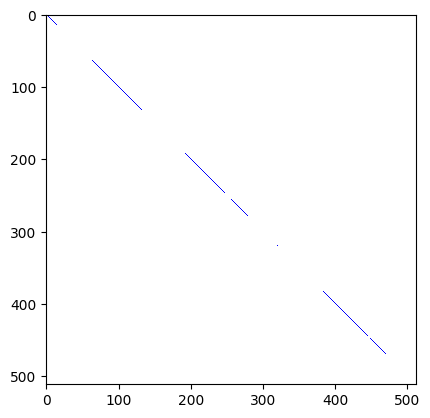

In [38]:
v_weight = model.model.layers[0].self_attn.v_proj.weight.data.to("cpu")
plt.imshow(v_weight@v_weight.T, cmap=cmap, interpolation='none')

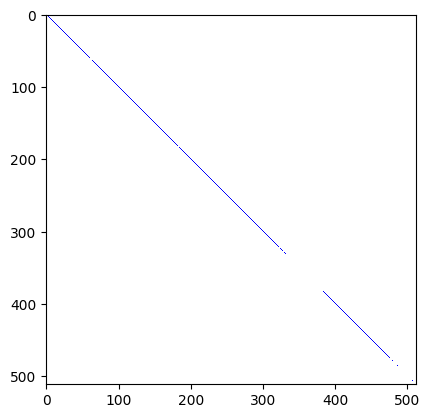

In [40]:
v_up_weight = model.model.layers[0].self_attn.v_up_proj.weight.data.to("cpu")
plt.imshow(v_up_weight.T@v_up_weight, cmap=cmap, interpolation='none')

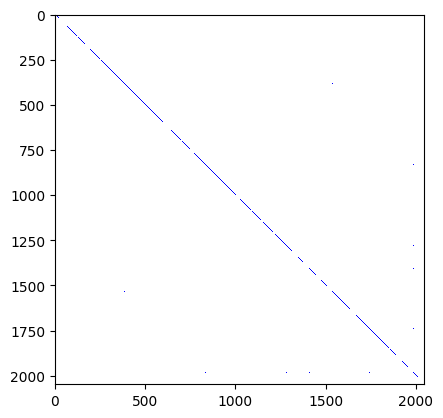

In [ ]:
o_weight = model.model.layers[0].self_attn.o_proj.weight.data.to("cpu")
plt.imshow(o_weight.T@o_weight, cmap=cmap, interpolation='none')